# SMART FACTORY ENERGY PREDICTION CHALLENGE

### Overview

This solution aims to tackle the smart factory energy prediction challenge by developing a robust machine learning model that can accurately predict the energy consumption of industrial equipment leveraging on a comprehensive feature engineering and modelling techniques.

### Objectives:
- Analyze the provided sensor data to identify patterns and relationships between environmental factors and equipment energy consumption
- Build a robust regression model to predict equipment energy consumption
- Evaluate the model's performance using appropriate metrics
- Provide actionable insights and recommendations for reducing energy consumption

## ETL Process

### Extract
- **Data Set**: equipment energy consumption at 10-minute intervals
- **Data Formats**: CSV

### Transform
1. **Data Cleaning**:
   - Conversion of timestamps to datetime objects
   - Removal of strings from certain columns and conversion to numeric values to be used for calculations

2. **Aggregation**:
   - Aggregation of 10-minute data to daily totals with multiple statistical metrics

3. **Feature Engineering**:
   - Creation of temporal features and cyclical encodings
   - Integration of data with some temperature metrics

### Load
- Load dataset for analysis

## Data Modeling

### Model Configurations
Three different LightGBM configurations were trained on the data:
1. **Precise**: Conservative approach with deep trees (max_depth=8, learning_rate=0.01)
2. **Feature Selective**: Aggressive feature selection (colsample_bytree=0.6, feature_fraction=0.7)
3. **Highly Regularized**: Strong regularization (reg_alpha=2.0, reg_lambda=2.0)

### Optimization Approach
- **Cross-Validation**: 5-fold cross-validation for robust model evaluation
- **Bayesian Optimization**: Used to find optimal weights for combining base models
- **Feature Importance Analysis**: Identified and leveraged the most predictive features
- **Performance Monitoring**: Tracked relevant metrics (RMSE, MSE, R2_Score)

## IMPORTING ALL NECESSARY LIBRARIES

In [272]:
# Make sure all the libraries are installed in your env
#!pip install -r requirements.txt --quiet

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import json

import datetime as dt
import time
import calendar

import logging

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split
from bayes_opt import BayesianOptimization

import random

import warnings
warnings.filterwarnings('ignore')

In [300]:
#Set random everything for reproduceability
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create folder for eda visualizations
os.makedirs('eda_visual', exist_ok=True)

## DATA LOADING AND INITIAL EXPLORATION

This section comprises of the loading of the dataset and exploration of some basic information about our dataset.

In [301]:
###########################################
# LOADING DATA
###########################################
logger.info("Loading data...")
start_time = time.time()

# Loading the data
df = pd.read_csv("data/data.csv")
logger.info(f"✓ Data loaded: {len(df):,} records")
# Displaying a part of the data
display(df.head())

# Checking for basic information about our data
display(df.info())

elapsed = time.time() - start_time
logger.info(f"Data loading completed in {elapsed:.2f} seconds")

2025-05-09 17:18:53,664 - INFO - Loading data...
2025-05-09 17:18:53,784 - INFO - ✓ Data loaded: 16,857 records


,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  float64
 13  z

None

2025-05-09 17:18:53,826 - INFO - Data loading completed in 0.16 seconds


## DATA PREPROCESSING AND AGGREGATION

This section comprises of

1. Conversion of timestamp to datetime objects
2. Aggregation of 10-minute data to daily totals

In [302]:
###########################################
# BASIC DATA PREPROCESSING
###########################################
start_time = time.time()
logger.info("Data Preprocessing and aggregation (multiple metrics)...")

# Conversion of timestamp to datetime object
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["Date"] = pd.to_datetime(df["timestamp"].dt.date)
df["Year"] = df["timestamp"].dt.year

# Conversion of columns from object to numeric columns for calculations
obj_col = [col for col in df.columns if df[col].dtype not in ["datetime64[ns]","float64", "int64"]]
for col in obj_col:
    df[col] = pd.to_numeric(df[col], errors = "coerce") # Corce string values present in data to null

    
# Filling in missing values
from sklearn.impute import SimpleImputer
null_col = []
for col in df.columns:
    if df[col].isnull().any()== True and df[col].isnull().mean()<0.4: # Dropping columns with null values greater than 40%
        null_col.append(col)

imputer = SimpleImputer(strategy="mean")
df[null_col] = imputer.fit_transform(df[null_col])

# Estmating the overall temperature and humidity within the facility
zones_readings = [col for col in df.columns if "zone" in col]
zone_temp_val = [col for col in zones_readings if "temperature" in col]
zone_hum_val = [col for col in zones_readings if "humidity" in col]

# Since we have 9 different zones with sensor readings for temperature and humidity, we can aggregate them to get an estimate of the average temperature and humidity (temperature and humidity within the facility)
df["indoor_temperature"] = df[zone_temp_val].mean(axis=1)
df["indoor_humidity"] = df[zone_hum_val].mean(axis=1)



###########################################
# DATA AGGREGATION
###########################################
# Defining aggregations for columns

aggreg_daily = {
    "equipment_energy_consumption" : "sum",
    "lighting_energy" : "sum",
    "outdoor_temperature": ["mean", "min", "max"],
    "atmospheric_pressure":["mean", "max"],
    "outdoor_humidity":["mean", "max"],
    "wind_speed":["mean", "max"],
    "visibility_index":["mean","max"],
    "dew_point":["mean", "min", "max"],
    "indoor_temperature":["mean", "min", "max"],
    "indoor_humidity":["mean", "max"],
    "random_variable1":"mean",
    "random_variable2":"mean" 
    
}

# Aggregation with already stated metrics
data = df.copy()
daily_data = data.groupby(["Date"]).agg(aggreg_daily)
#Flatten multi-index column names
daily_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in daily_data.columns.values]
daily_data = daily_data.reset_index()
logger.info(f"Aggregated data: {len(daily_data)} records")

# Since the year is the same, we can extract week number from the Date components
daily_data['Week'] = daily_data['Date'].dt.isocalendar().week

# Display sample of aggregated data
display(daily_data.head())
logger.info(f"Data Aggregation completed in {elapsed:.2f} seconds")

2025-05-09 17:18:54,654 - INFO - Data Preprocessing and aggregation (multiple metrics)...
2025-05-09 17:18:54,809 - INFO - Aggregated data: 129 records


,Date,equipment_energy_consumption_sum,lighting_energy_sum,outdoor_temperature_mean,outdoor_temperature_min,outdoor_temperature_max,atmospheric_pressure_mean,atmospheric_pressure_max,outdoor_humidity_mean,outdoor_humidity_max,...,dew_point_min,dew_point_max,indoor_temperature_mean,indoor_temperature_min,indoor_temperature_max,indoor_humidity_mean,indoor_humidity_max,random_variable1_mean,random_variable2_mean,Week
0,2016-01-11,5817.431238,1090.088416,5.922619,5.400000,6.600000,737.604476,755.757602,95.106176,221.668765,...,-32.098095,37.673716,17.547683,11.102215,21.213849,51.554882,56.431926,25.799244,22.723585,2
1,2016-01-12,12332.293713,478.392013,4.990147,-37.524768,49.853906,743.509336,755.757602,87.180569,221.668765,...,-32.098095,4.166667,17.430835,12.223749,23.299141,50.172600,81.913670,22.283654,27.318153,2
2,2016-01-13,10307.350478,679.778922,5.894474,-37.524768,49.853906,754.861278,833.392675,79.736396,221.668765,...,-0.100000,37.673716,16.866044,11.548087,19.551500,47.576416,76.655151,23.603055,23.225500,2
3,2016-01-14,21513.132277,616.209283,3.935362,-37.524768,49.853906,749.356203,755.757602,84.619476,221.668765,...,-32.098095,37.673716,17.322868,12.173256,20.139217,48.754198,59.057423,23.341088,28.166310,2
4,2016-01-15,19950.926031,510.353665,2.603891,-37.524768,6.218582,754.026779,833.392675,85.425092,221.668765,...,-32.098095,37.673716,17.999219,11.955108,20.623237,46.324991,75.852109,25.422985,26.329498,2


2025-05-09 17:18:54,823 - INFO - Data Aggregation completed in 0.16 seconds


## EXPLORATORY DATA ANALYSIS AND VISUALIZATIONS

In this section, we perform some analysis on our data to examine some relationships that may exists between datapoints, features and also draw insights that could prove useful in feature selection


===== EQUIPMENT ENERGY CONSUMPTION STATISTICS =====
count      129.000000
mean     12519.969954
std       5564.223743
min         30.000000
25%      10193.537714
50%      12332.293713
75%      16150.267450
max      26474.065907
Name: equipment_energy_consumption_sum, dtype: float64


2025-05-09 17:18:57,621 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-09 17:18:57,629 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-09 17:18:57,821 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-09 17:18:57,828 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


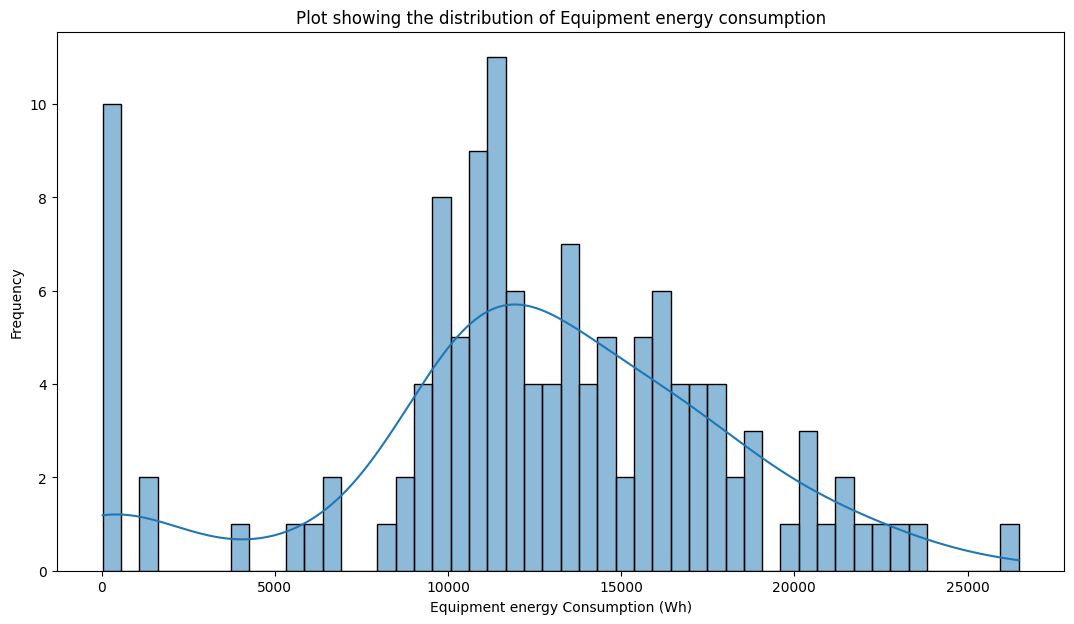

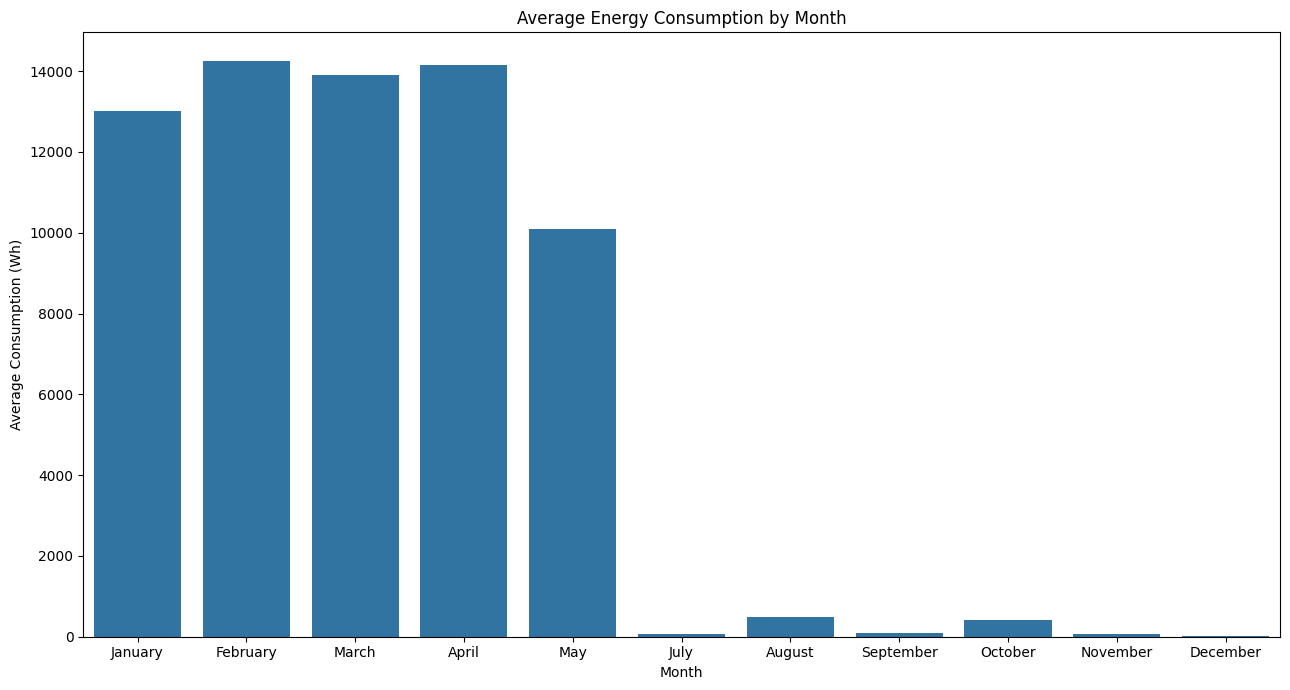

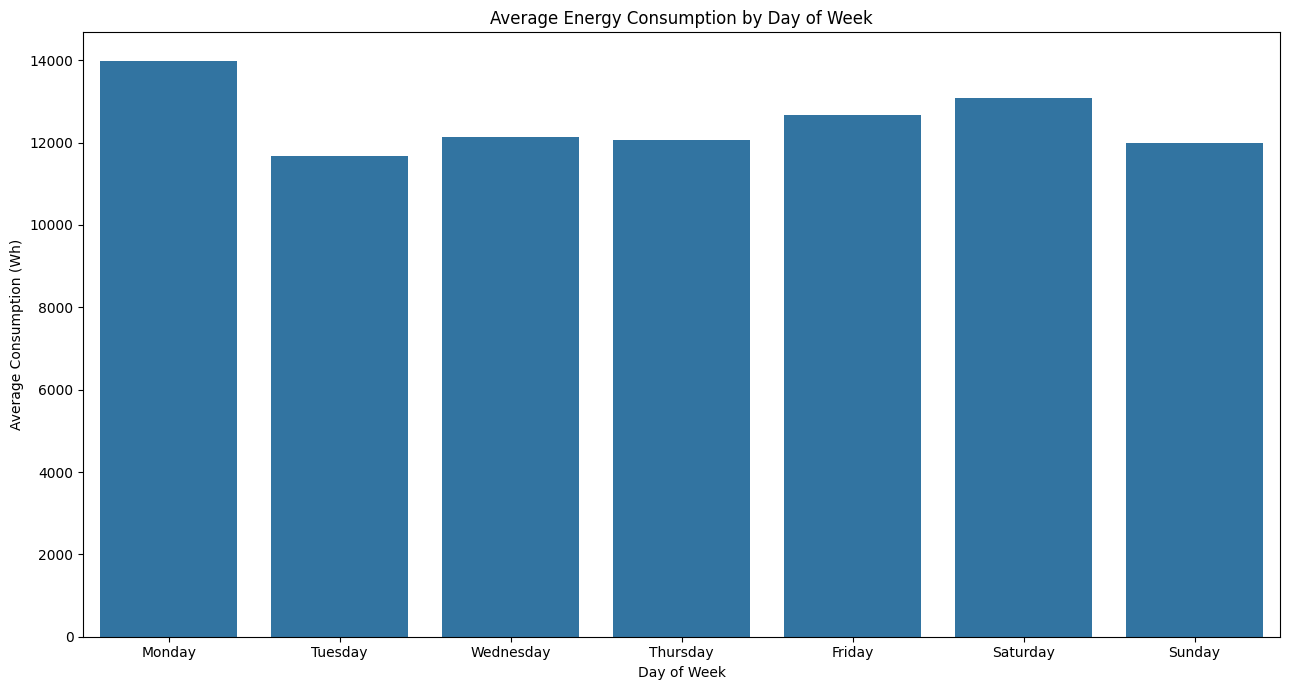

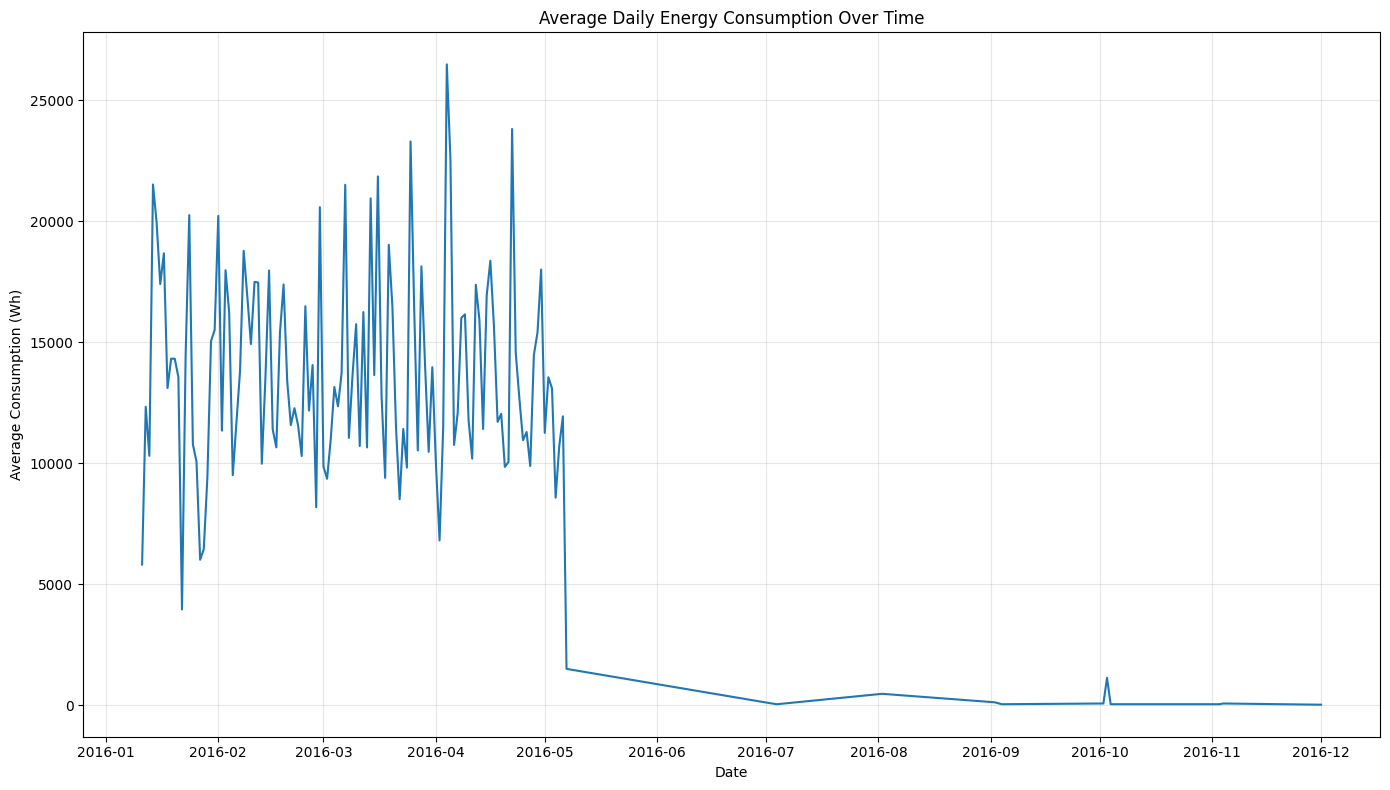

In [303]:
###########################################
#  EDA & VISUALIZATIONS
###########################################

# Additional columns for data visualizations
daily_data["Month"] = daily_data["Date"].dt.month
daily_data["Day"] = daily_data["Date"].dt.day
daily_data["Weekday"] = daily_data["Date"].dt.dayofweek
daily_data["WeekOfYear"] = daily_data["Date"].dt.isocalendar().week

print("\n===== EQUIPMENT ENERGY CONSUMPTION STATISTICS =====")
print(daily_data["equipment_energy_consumption_sum"].describe())

# 1) Equipment energy consumption
plt.figure(figsize=(13, 7))
sns.histplot(daily_data["equipment_energy_consumption_sum"], bins=50, kde=True)
plt.title("Plot showing the distribution of Equipment energy consumption")
plt.xlabel("Equipment energy Consumption (Wh)")
plt.ylabel("Frequency")
plt.savefig("eda_visual/equipment_energy_consumption.png")


# 2) Monthly Consumption
monthly_consumption = daily_data.groupby("Month")["equipment_energy_consumption_sum"].agg(["mean", "median", "std", "count"]).reset_index()
monthly_consumption["month_name"] = monthly_consumption["Month"].apply(lambda x: calendar.month_name[x])
monthly_consumption = monthly_consumption.sort_values("Month")

plt.figure(figsize=(13, 7))
sns.barplot(x="month_name", y="mean", data=monthly_consumption)
plt.title("Average Energy Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Average Consumption (Wh)")
plt.tight_layout()
plt.savefig("eda_visual/monthly_consumption.png")

# 3) Consumption by Day of Week
wkday_consumption = daily_data.groupby("Weekday")["equipment_energy_consumption_sum"].agg(["mean", "median", "std", "count"]).reset_index()
wkday_consumption["day_name"] = wkday_consumption["Weekday"].apply(lambda x: calendar.day_name[x])
wkday_consumption = wkday_consumption.sort_values("Weekday")

plt.figure(figsize=(13, 7))
sns.barplot(x="day_name", y="mean", data=wkday_consumption)
plt.title("Average Energy Consumption by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Consumption (Wh)")
plt.tight_layout()
plt.savefig("eda_visual/dayofweek_consumption.png")

# 4) Daily Trend
daily_avg = daily_data.groupby("Date")["equipment_energy_consumption_sum"].mean().reset_index()
plt.figure(figsize=(14, 8))
plt.plot(daily_avg["Date"], daily_avg["equipment_energy_consumption_sum"])
plt.title("Average Daily Energy Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Average Consumption (Wh)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('eda_visual/daily_consumption_trend.png')

### SOME INSIGHTS FROM EDA

- The Average daily energy consumption between January and April has a discernable and considerably consistent pattern of variation but by May, a significant drop in the energy consumption can be seen from the plot.
- The highest daily energy consumption occurs around April

In [1]:
# Exploring any relationship that may exist between the random variables and our target
rndm1 = data.groupby("Date")["random_variable1"].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(rndm1["Date"], rndm1["random_variable1"])
plt.title("Mean value of random_variable1 over time")
plt.xlabel("Date")
plt.ylabel("random_variable1")
plt.grid(True, alpha=0.3)
plt.tight_layout()

rndm2 = data.groupby("Date")["random_variable2"].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(rndm2["Date"], rndm2["random_variable2"])
plt.title("Mean value of random_variable2 over time")
plt.xlabel("Date")
plt.ylabel("random_variable2")
plt.grid(True, alpha=0.3)
plt.tight_layout()

NameError: name 'data' is not defined

It can be observed that there seems to be a similarity in the behavioral pattern of these random variables like was observed with the average daily energy consumption:
- Both variables appear to have a somewhat similar trend with time.
- Consistent variation pattern between January and May and after that no discernable pattern is seen.

This could be indication that there is a relationship that exists with the target variable, we can verify from the pearson correlation coefficient if it's okay to keep them.

In [280]:
# Examining the correlation that both variables have with the target variable
daily_data[["random_variable1_mean", "random_variable2_mean", "equipment_energy_consumption_sum"]] .corr()["equipment_energy_consumption_sum"]

random_variable1_mean               0.147089
random_variable2_mean               0.228120
equipment_energy_consumption_sum    1.000000
Name: equipment_energy_consumption_sum, dtype: float64

Since they both have a pearson coefficient greater than 1, even though we don't know what both variables represent, we could still adopt them. A feature importance plot at the end of the evaluation can further reveal to us if we made the right decision.

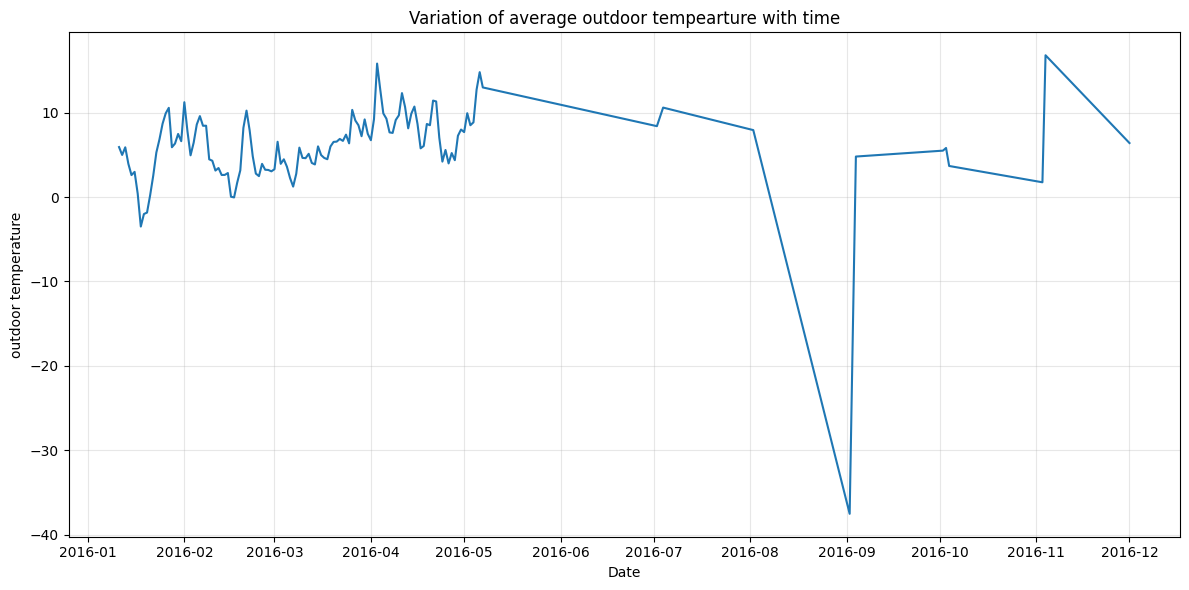

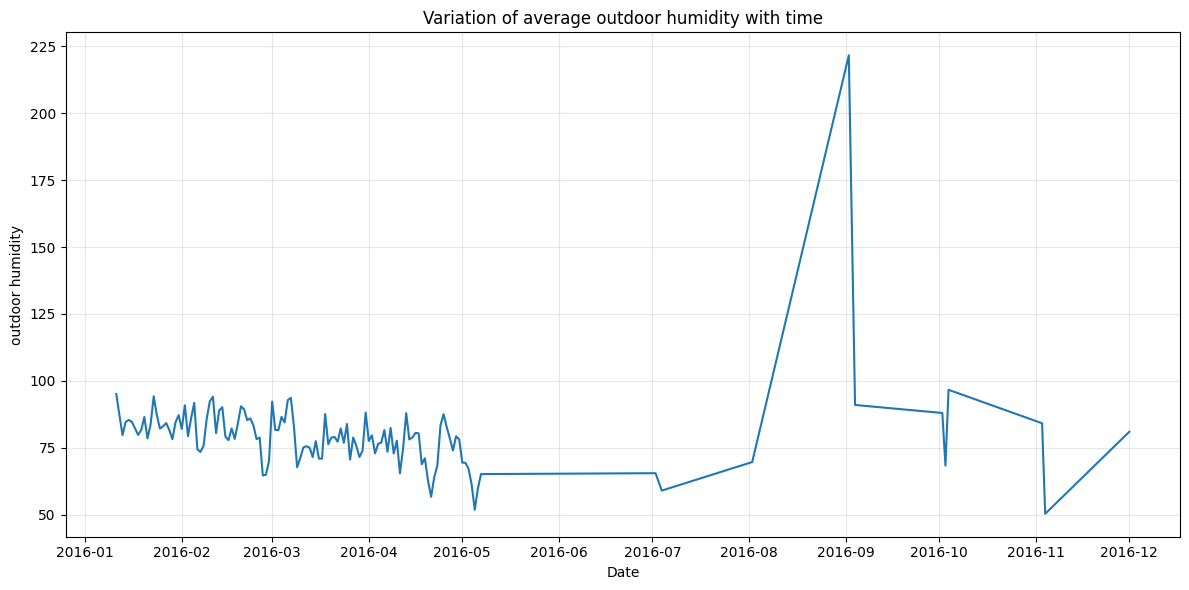

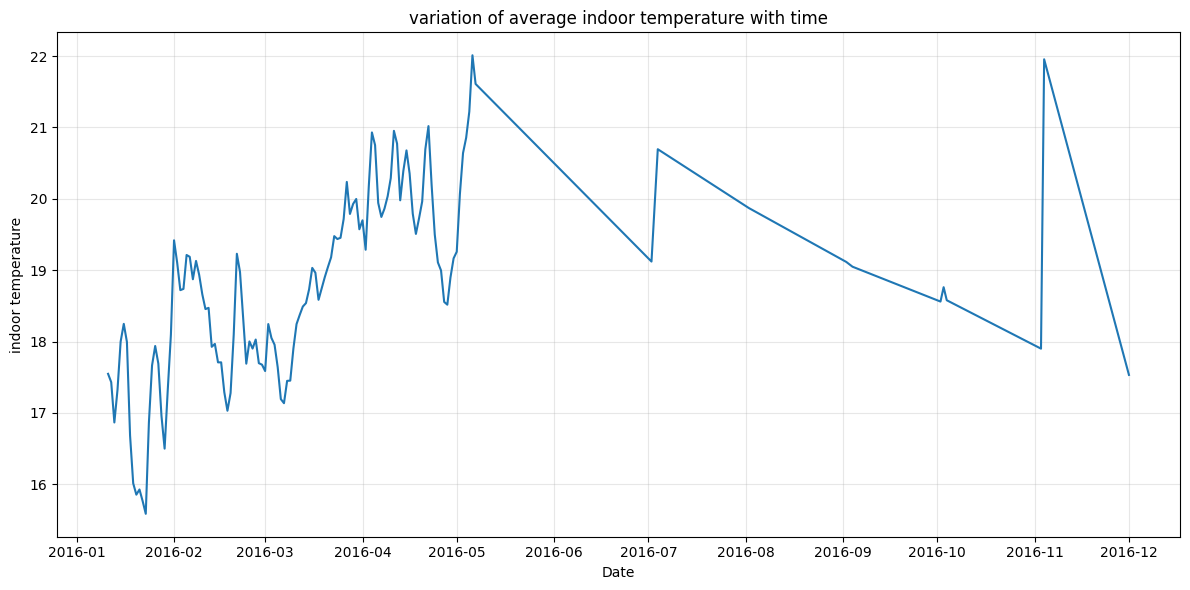

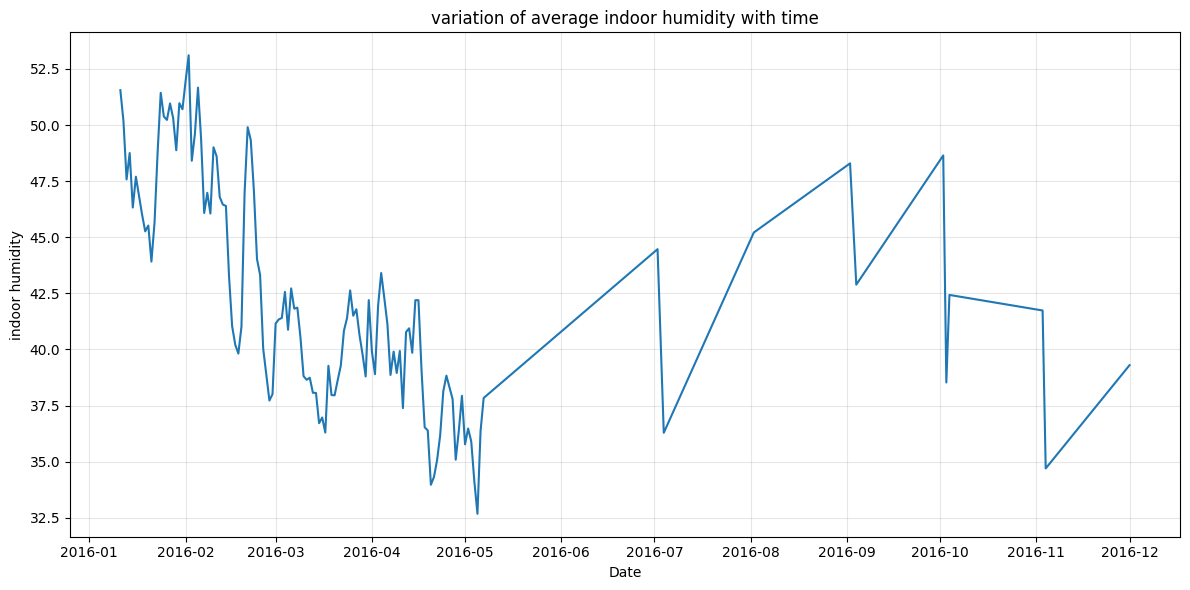

In [281]:
# Examining other environmental factors to see if the pattern of variation with the equipment energy consumption is consistent

# Outdoor temperature
# -----------------------
outtemp = data.groupby("Date")["outdoor_temperature"].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(outtemp["Date"],outtemp["outdoor_temperature"])
plt.title("Variation of average outdoor tempearture with time")
plt.xlabel("Date")
plt.ylabel("outdoor temperature")
plt.grid(True, alpha=0.3)
plt.tight_layout()


# Outdoor humidity
# -----------------------
outhum = data.groupby("Date")["outdoor_humidity"].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(outhum["Date"], outhum["outdoor_humidity"])
plt.title("Variation of average outdoor humidity with time")
plt.xlabel("Date")
plt.ylabel("outdoor humidity")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Indoor temperature
# -----------------------
intemp = data.groupby("Date")["indoor_temperature"].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(intemp["Date"], intemp["indoor_temperature"])
plt.title("variation of average indoor temperature with time")
plt.xlabel("Date")
plt.ylabel("indoor temperature")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Indoor humidity
# -----------------------
inhum = data.groupby("Date")["indoor_humidity"].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(inhum["Date"], inhum["indoor_humidity"])
plt.title("variation of average indoor humidity with time")
plt.xlabel("Date")
plt.ylabel("indoor humidity")
plt.grid(True, alpha=0.3)
plt.tight_layout()

A similitude of the pattern seen with the equipment energy consumption may be noticed with some of the environmental conditions shown above even though more peculiar trends are seen (like indoor humidity general decreasing pattern from January to May and indoor temperature exhibiting an inverse behaviour to the humidity), the same idea holds that after May, that consistent trend seems lost.
Observing each of the environmental conditions closely, we can conclude that no one condition specifically stands out as the singular influence and factor for the behaviour of the energy consumption variable after May because though the consistency in trend isn't seen after May there are still significant peaks and troughs the same of which cannot be said of our equipment energy consumption variable

## ADVANCED FEATURE ENGINEERING

This section defines and implements:
1. Cyclical temporal encodings
2. Advanced climate features

In [304]:

logger.info("Adding advanced features...")

# 1. CYCLICAL TEMPORAL FEATURES
#-----------------------------------------
# Cyclical encoding of day of week (0-6)
daily_data["Weekday_sin"] = np.sin(daily_data["Weekday"] * (2 * np.pi / 7))
daily_data["Weekday_cos"] = np.cos(daily_data["Weekday"] * (2 * np.pi / 7))

# Cyclical encoding of day of year (1-366)
daily_data["day_of_year"] = daily_data["Date"].dt.dayofyear
daily_data["doy_sin"] = np.sin(daily_data["day_of_year"] * (2 * np.pi / 365.25))
daily_data["doy_cos"] = np.cos(daily_data["day_of_year"] * (2 * np.pi / 365.25))

# Cyclical encoding of month (1-12)
daily_data["month_sin"] = np.sin(daily_data["Month"] * (2 * np.pi / 12))
daily_data["month_cos"] = np.cos(daily_data["Month"] * (2 * np.pi / 12))

# Cyclical encoding of week (1-52)
daily_data["week_sin"] = np.sin(daily_data["Week"] * (2 * np.pi / 52))
daily_data["week_cos"] = np.cos(daily_data["Week"] * (2 * np.pi / 52))


#-----------------------------------------
# 2. CLIMATE-RELATED FEATURES
#-----------------------------------------
# Calculate variations in temperature
daily_data["mean_temp_diff"] = daily_data["outdoor_temperature_mean"] - daily_data["indoor_temperature_mean"]
daily_data["outdoor_temp_daily_range"] = daily_data["outdoor_temperature_max"] - daily_data["indoor_temperature_min"]
daily_data["indoor_temp_daily_range"] = daily_data["indoor_temperature_max"] - daily_data["indoor_temperature_min"]

# Temperature and dew point
daily_data["temp_dew_diff"] = daily_data["outdoor_temperature_mean"] - daily_data["dew_point_mean"]

# Degree days (heating - base 18°C/ cooling - base 24°C)
daily_data["heating_degree_days"] = np.maximum(18 - daily_data["outdoor_temperature_mean"], 0)
daily_data["cooling_degree_days"] = np.maximum(daily_data["outdoor_temperature_mean"] - 24, 0)

2025-05-09 17:23:40,120 - INFO - Adding advanced features...


## MODEL TRAINING

This section implements our model training which comprises:
- A cross-validation training function with Bayesian optimization for ensemble weights

The training function trains 3 different LightGBM models with varied configurations, then uses Bayesian optimization to find the optimal weights for combining their predictions.

In [284]:
def train_cv_model(data, n_folds=5):

    logger.info(f"========== START TRAINING MODEL ==========")
    logger.info(f"Training model with stacking of 3 LGBMs (CV {n_folds}-folds)...")
    logger.info(f"Input data: {len(data)} samples with {len(data.columns)} columns")

    start_time = time.time()
    
    # Define target variable column
    tar_var = "equipment_energy_consumption_sum"
    logger.info(f"Detected target column: {tar_var}")

    # List columns to be excluded from training
    exclude_cols = [
        "Date", "equipment_energy_consumption_sum", "equipment_energy_consumption", "Month", "WeekOfYear", "day_of_year", 
        "Week", "Date", "week_sin", "outdoor_temp_mean", "cooling_days"]
    logger.info(f"Total of {len(exclude_cols)} columns excluded from training")
    
    X = data.drop(columns=exclude_cols, errors='ignore')
    y = data[tar_var].values

    logger.info(f"Prepared dataset: X shape={X.shape}, y shape={y.shape}")
    logger.info(f"Target statistics: min={y.min():.4f}, max={y.max():.4f}, mean={y.mean():.4f}, median={np.median(y):.4f}")

    # 3 detected lgbm configurations
    lgbm_configs = [
        # Model 1: precise
        {
            'name': 'precise',
            'params': {
                'n_estimators': 2000,
                'learning_rate': 0.01,
                'max_depth': 8,
                'num_leaves': 31,
                'colsample_bytree': 0.8,
                'subsample': 0.8,
                'reg_alpha': 0.1,
                'reg_lambda': 0.1,
                'min_child_weight': 10,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }
        },
    # Model 2: feature_selective
        {
            'name': 'feature_selective',
            'params': {
                'n_estimators': 1500,
                'learning_rate': 0.02,
                'max_depth': 6,
                'colsample_bytree': 0.6,
                'subsample': 0.9,
                'reg_alpha': 1.0,
                'reg_lambda': 0.1,
                'feature_fraction': 0.7,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }
        },
    # Model 3: Highly regularized 
        {
            'name': 'highly_regularized',
            'params': {
                'n_estimators': 1200,
                'learning_rate': 0.02,
                'max_depth': 4,
                'num_leaves': 16,
                'colsample_bytree': 0.7,
                'subsample': 0.8,
                'reg_alpha': 2.0,
                'reg_lambda': 2.0,
                'min_child_weight': 15,
                'min_data_in_leaf': 25,
                'random_state': 42,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'early_stopping_rounds': 100
            }
        }
    ]
    logger.info(f"Configuration of {len(lgbm_configs)} LightGBM models with different parameters")

    # Cross validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    models = []  # Final model list to return (consistent with original function)
    optimal_weights_list = []  # Storage for optimal weights for each fold
    cv_scores_rmse = []
    cv_scores_mse = []
    oof_preds = np.zeros(len(data))
    oof_base_preds = np.zeros((len(data), len(lgbm_configs)))

    logger.info(f"Starting training with {n_folds}-fold cross-validation")

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X)):
        fold_start_time = time.time()
        logger.info(f"=====================")
        logger.info(f"Fold {fold+1}/{n_folds}")
        logger.info(f"Train: {len(tr_idx)} samples, Validation: {len(val_idx)} samples")
        X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_train, y_val = y[tr_idx], y[val_idx]

        logger.info(f"y_train statistics: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
        logger.info(f"y_val statistics: min={y_val.min():.4f}, max={y_val.max():.4f}, mean={y_val.mean():.4f}")

        fold_models = []
        fold_preds = np.zeros((len(X_val), len(lgbm_configs)))

        # Training each base model
        for i, config in enumerate(lgbm_configs):
            model_start_time = time.time()
            logger.info(f"  ---------------------")
            logger.info(f"  Training model {i+1}/{len(lgbm_configs)} ({config['name']})...")
            logger.info(f"  Parameters: {json.dumps(config['params'], indent=2)}")

            model = LGBMRegressor(**config['params'])

            try:
                logger.info(f"  Starting training...")
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    categorical_feature=cat_feats
                )

                logger.info(f"  Training completed successfully in {time.time() - model_start_time:.2f} seconds")
                logger.info(f"  Best iteration: {model.best_iteration_}")
                # Predictions on validation set
                val_preds = model.predict(X_val)
                fold_preds[:, i] = val_preds
                oof_base_preds[val_idx, i] = val_preds
                
            
                fold_models.append(model)
                
                # Display metrics for this model
                rmse = np.sqrt(mean_squared_error(y_val, val_preds))
                logger.info(f"  Model {config['name']} - RMSE: {rmse:.6f}")
                mae = mean_squared_error(y_val, val_preds)
                logger.info(f"  Model {config['name']} - MSE: {mse:.6f}")
                r2 = r2_score(y_val, val_preds)
                logger.info(f"  Prediction statistics: min={val_preds.min():.4f}, max={val_preds.max():.4f}, mean={val_preds.mean():.4f}")

            except Exception as e:
                logger.error(f"  ERROR during training of model {config['name']}: {str(e)}")
                # Placeholder model with default parameters if training fails
                placeholder_model = LGBMRegressor(n_estimators=100)
                placeholder_model.fit(X_train, y_train)
                fold_models.append(placeholder_model)
                fold_preds[:, i] = placeholder_model.predict(X_val)
                oof_base_preds[val_idx, i] = fold_preds[:, i]

        # Instead of using a meta-model, find optimal weights with Bayesian optimization
        logger.info(f"  ---------------------")
        logger.info(f"  Searching for optimal weights with Bayesian optimization...")

        # Objective function for Bayesian optimization
        def objective_function(**weights):
            # Convert dictionary to array
            w = np.array([weights[f'w{i}'] for i in range(len(lgbm_configs))])
            
            # Normalize weights to sum to 1
            w = w / np.sum(w)
            
            # Weighted prediction
            weighted_pred = np.zeros(len(y_val))
            for i in range(len(lgbm_configs)):
                weighted_pred += w[i] * fold_preds[:, i]
            
            # Calculate negative error (because we maximize)
            neg_rmse = -np.sqrt(mean_squared_error(y_val, weighted_pred))
            return neg_rmse
        
        # Define bounds for optimization - all weights between 0 and 1
        pbounds = {f'w{i}': (0, 1) for i in range(len(lgbm_configs))}
        
        # Run Bayesian optimization
        optimizer = BayesianOptimization(
            f=objective_function,
            pbounds=pbounds,
            random_state=42,
            verbose=0
        )

        optimizer.maximize(init_points=10, n_iter=50)
        
        # Get best parameters and normalize
        best_params = optimizer.max['params']
        optimal_weights = np.array([best_params[f'w{i}'] for i in range(len(lgbm_configs))])
        optimal_weights = optimal_weights / np.sum(optimal_weights)
        optimal_weights_list.append(optimal_weights)

        # Record optimal weights
        logger.info(f"  Optimal weights found: {', '.join([f'{w:.4f}' for w in optimal_weights])}")
        # Calculate final predictions with optimal weights
        final_val_preds = np.zeros(len(y_val))
        for i in range(len(lgbm_configs)):
            final_val_preds += optimal_weights[i] * fold_preds[:, i]
        
        oof_preds[val_idx] = final_val_preds
        
        # Calculate final RMSE
        rmse = np.sqrt(mean_squared_error(y_val, final_val_preds))
        cv_scores_rmse.append(rmse)
        logger.info(f"  Bayesian optimization - RMSE: {rmse:.6f}")        
        mse = mean_squared_error(y_val, final_val_preds)
        cv_scores_mse.append(mse)
        logger.info(f"  Bayesian optimization - MSE: {mse:.6f}")        
        logger.info(f"  Final prediction statistics: min={final_val_preds.min():.4f}, max={final_val_preds.max():.4f}, mean={final_val_preds.mean():.4f}")

        # Store models
        models.append(fold_models)

        if fold == 0 and len(fold_models) > 0:
            try:
                feature_imp = pd.DataFrame({
                    'Value': fold_models[0].feature_importances_,
                    'Feature': X.columns
                }).sort_values(by='Value', ascending=False)
                plt.figure(figsize=(12, 6))
                sns.barplot(x='Value', y='Feature', data=feature_imp.head(20))
                plt.title(f'Top 20 Features - {model_name}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                logger.error(f"Error when displaying important features: {str(e)}")

         logger.info(f"Fold {fold+1} completed in {time.time() - fold_start_time:.2f} seconds")

    oof_rmse = np.sqrt(mean_squared_error(y, oof_preds))
    logger.info(f"OOF RMSE for {model_name} (with optimal weights): {oof_rmse:.6f}")
    logger.info(f"OOF prediction statistics: min={oof_preds.min():.4f}, max={oof_preds.max():.4f}, mean={oof_preds.mean():.4f}")

    oof_mse = mean_squared_error(y, oof_preds)

    oof_r2 = r2_score(y, oof_preds)


    total_time = time.time() - start_time
    logger.info(f"Complete training finished in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    logger.info(f"========== END TRAINING ==========")

    return models, X.columns, cv_scores_rmse, cv_scores_mse, oof_preds, oof_rmse, oof_mse, oof_r2

## MODEL TRAINING AND EVALUATION

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 103, number of used features: 36
[LightGBM] [Info] Start training from score 12369.971242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

{'Mean CV RMSE': np.float64(4737.6392085656935),
 'Mean CV MSE': np.float64(3640274.5145187154),
 'OOF RMSE': np.float64(4751.815432306161),
 'OOF MSE': 22579749.902702983,
 'OOF R2_Score': 0.26499600812982516}

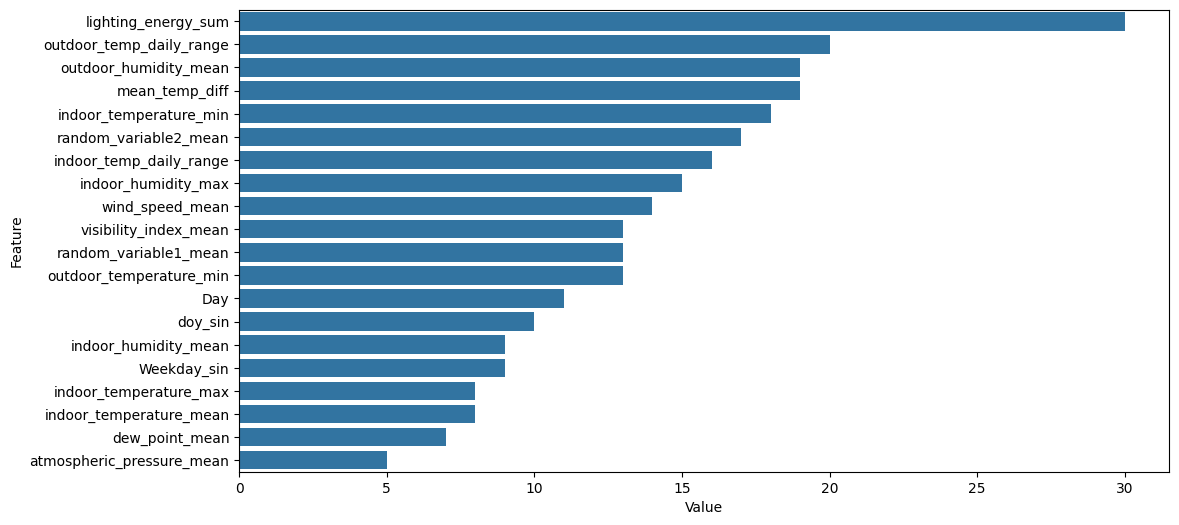

In [286]:
###########################################
# MODEL TRAINING
###########################################

logger.info("Training Model")
models, cols, cv_scores_rmse, cv_scores_mse, oof_preds, oof_rmse, oof_mse, oof_r2 = train_cv_model(daily_data, n_folds=5)

# Display model performance comparison
model_perf = {
    'Mean CV RMSE': np.mean(cv_scores_rmse),
    'Mean CV MSE': np.std(cv_scores_mse),
    'OOF RMSE': oof_rmse,
    'OOF MSE': oof_mse,
    'OOF R2_Score': oof_r2
}
display(model_perf)

Due to the size of the dataset provided, taking out an extra test set for further testing wouldn't be feasible as it would mean taking out of the already insufficient data provided for training and validation. 